In [1]:
import os

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import seaborn as sns
import yaml
from sklearn import metrics
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

from autodefer.models import hyperoptimization
from autodefer.utils import plotting

In [2]:
# import matplotlib; matplotlib.use('Agg')  # turns plotting off (faster debugging)
sns.set_style('whitegrid')
width = 450
pd.set_option('display.width', width)
np.set_printoptions(linewidth=width)
pd.set_option('display.max_columns', 25)

root_path = '~'
cfg_path = root_path + 'learning-to-defer/experiments/baf_haic/assigners/cfg.yaml'
with open(cfg_path, 'r') as infile:
    cfg = yaml.safe_load(infile)

RESULTS_PATH = cfg['results_path'] + cfg['exp_name'] + '/'
MODELS_PATH = cfg['models_path'] + cfg['exp_name'] + '/'

os.makedirs(RESULTS_PATH, exist_ok=True)
os.makedirs(MODELS_PATH, exist_ok=True)

In [3]:
# DATA LOADING
with open(cfg['metadata'], 'r') as infile:
    metadata = yaml.safe_load(infile)

LABEL_COL = metadata['data_cols']['label']
PROTECTED_COL = metadata['data_cols']['protected']
CATEGORICAL_COLS = metadata['data_cols']['categorical']

EXPERT_IDS = metadata['expert_ids']
BATCH_COL = metadata['data_cols']['batch']
ASSIGNMENT_COL = metadata['data_cols']['assignment']
DECISION_COL = metadata['data_cols']['decision']

# train
haic_train = pd.read_parquet(cfg['train_paths']['data'])
haic_train = haic_train.drop(columns=BATCH_COL)  # not needed

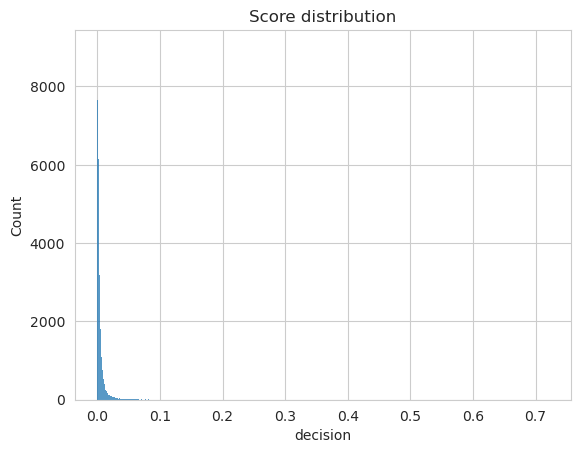

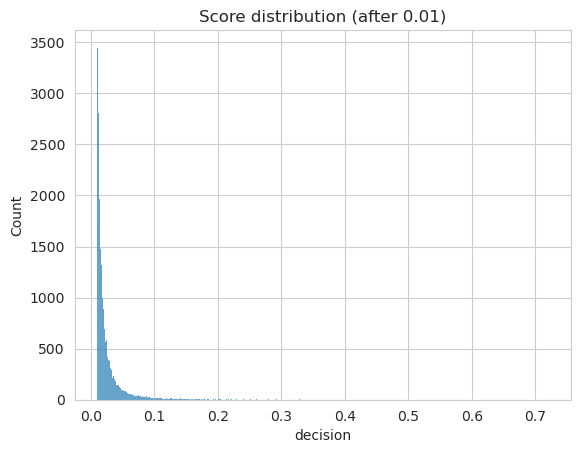

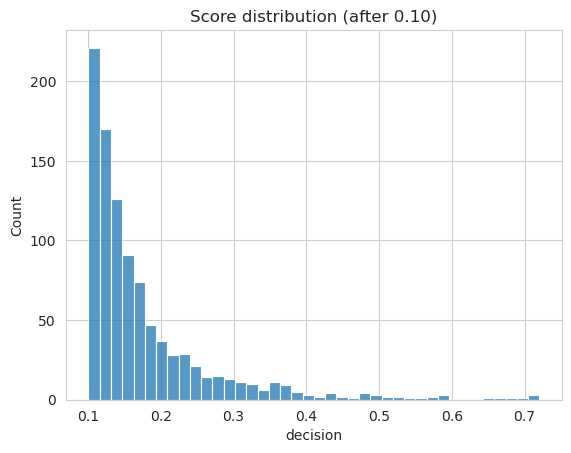

In [4]:
# ML MODEL ERROR MODELLING
haic_train_ml_model = haic_train[haic_train[ASSIGNMENT_COL] == 'model#0']

# plotting.hist_of_means(haic_train_ml_model[DECISION_COL], haic_train_ml_model[LABEL_COL])

# score dist
sns.histplot(haic_train_ml_model[DECISION_COL])
plt.title('Score distribution')
plt.show()

cutoff = 0.01
sns.histplot(haic_train_ml_model[DECISION_COL][haic_train_ml_model[DECISION_COL] > cutoff])
plt.title(f'Score distribution (after {cutoff:.2f})')
plt.show()

cutoff = 0.1
sns.histplot(haic_train_ml_model[DECISION_COL][haic_train_ml_model[DECISION_COL] > cutoff])
plt.title(f'Score distribution (after {cutoff:.2f})')
plt.show()

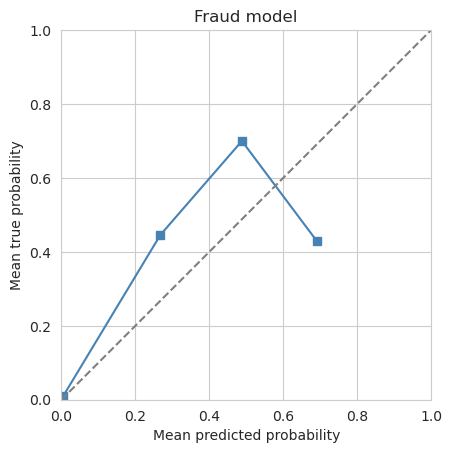

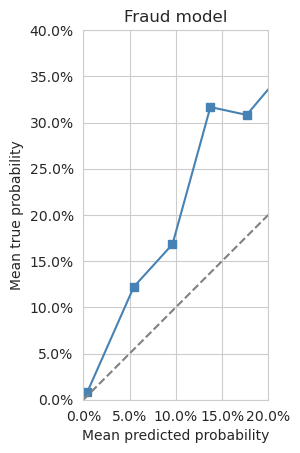

In [5]:
# calibration
prob_true, prob_pred = calibration_curve(
    y_true=haic_train_ml_model[LABEL_COL],
    y_prob=haic_train_ml_model[DECISION_COL],
    n_bins=5
)

plt.plot(prob_pred, prob_true, color='steelblue', marker='s')
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), linestyle='dashed', color='grey')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal')
plt.xlabel('Mean predicted probability')
plt.ylabel('Mean true probability')
plt.title('Fraud model')
plt.show()

cutoff = 0.2
prob_true, prob_pred = calibration_curve(
    y_true=haic_train_ml_model[LABEL_COL],
    y_prob=haic_train_ml_model[DECISION_COL],
    n_bins=int(5 * (1/cutoff))
)
plt.plot(prob_pred, prob_true, color='steelblue', marker='s')
plt.plot(np.linspace(0, cutoff, 100), np.linspace(0, cutoff, 100), linestyle='dashed', color='grey')
plt.xlim(0, cutoff)
plt.ylim(0, cutoff*2)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=1))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=1))
plt.gca().set_aspect('equal')
plt.xlabel('Mean predicted probability')
plt.ylabel('Mean true probability')
plt.title('Fraud model')
plt.show()

In [6]:
# HUMAN EXPERT MODELLING

# drop machine learning model; only modelling experts
haic_train = haic_train[haic_train[ASSIGNMENT_COL] != 'model#0']
haic_train[DECISION_COL] = haic_train[DECISION_COL].astype(int)

OUTCOME_COL = 'error'
FN_COL = 'fn'
FP_COL = 'fp'

def get_outcome(label, pred):
    if pred == 1:
        if label == 1:
            o = 'tp'
        elif label == 0:
            o = 'fp'
    elif pred == 0:
        if label == 1:
            o = 'fn'
        elif label == 0:
            o = 'tn'
    return o

haic_train[OUTCOME_COL] = haic_train.apply(
    lambda x: get_outcome(label=x[LABEL_COL], pred=x[DECISION_COL]),
    axis=1,
)
haic_train[FN_COL] = (haic_train[OUTCOME_COL] == FN_COL).astype(int)
haic_train[FP_COL] = (haic_train[OUTCOME_COL] == FP_COL).astype(int)

LABEL_COLS = [LABEL_COL, DECISION_COL, OUTCOME_COL, FN_COL, FP_COL]

train, val = train_test_split(haic_train, test_size=0.25, shuffle=False)

# preprocessing
to_encode = [*CATEGORICAL_COLS, ASSIGNMENT_COL]
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
train[to_encode] = oe.fit_transform(train[to_encode])
train[to_encode] = train[to_encode].astype('category').copy()  # for LGBM
val[to_encode] = oe.transform(val[to_encode])
val[to_encode] = val[to_encode].astype('category').copy()  # for LGBM

EXPERT_IDS_ENCODED = list(train[ASSIGNMENT_COL].unique())

# random search
fn_model_tuner = hyperoptimization.BinaryClassTuner(
    sampler='random',
    outputs_dir=MODELS_PATH + 'fn/',
    random_seed=cfg['rma_params']['random_seed'],
)
_ = fn_model_tuner.run(
    X_train=train.drop(columns=LABEL_COLS), y_train=train[FN_COL],
    X_val=val.drop(columns=LABEL_COLS), y_val=val[FN_COL],
    hyperparam_space=cfg['rma_params']['hyperparam_space'],
    evaluation_function=lambda y_true, y_pred: -metrics.log_loss(y_true=y_true, y_pred=y_pred),
    n_trials=cfg['rma_params']['n_trials'],
)

fp_model_tuner = hyperoptimization.BinaryClassTuner(
    sampler='random',
    outputs_dir=MODELS_PATH + 'fp/',
    random_seed=cfg['rma_params']['random_seed'],
)
_ = fp_model_tuner.run(
    X_train=train.drop(columns=LABEL_COLS), y_train=train[FP_COL],
    X_val=val.drop(columns=LABEL_COLS), y_val=val[FP_COL],
    hyperparam_space=cfg['rma_params']['hyperparam_space'],
    evaluation_function=lambda y_true, y_pred: -metrics.log_loss(y_true=y_true, y_pred=y_pred),
    n_trials=cfg['rma_params']['n_trials'],
)

pp_model_tuner = hyperoptimization.BinaryClassTuner(
    sampler='random',
    outputs_dir=MODELS_PATH + 'pp/',
    random_seed=cfg['rma_params']['random_seed'],
)
_ = pp_model_tuner.run(
    X_train=train.drop(columns=LABEL_COLS), y_train=train[DECISION_COL],
    X_val=val.drop(columns=LABEL_COLS), y_val=val[DECISION_COL],
    hyperparam_space=cfg['rma_params']['hyperparam_space'],
    evaluation_function=lambda y_true, y_pred: -metrics.log_loss(y_true=y_true, y_pred=y_pred),
    n_trials=cfg['rma_params']['n_trials'],
)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [7]:
# tpe
fn_model_tuner_tpe = hyperoptimization.BinaryClassTuner(
    sampler='tpe',
    outputs_dir=MODELS_PATH + 'fn_tpe/',
    random_seed=cfg['rma_params']['random_seed'],
)
fn_model = fn_model_tuner_tpe.run(
    X_train=train.drop(columns=LABEL_COLS), y_train=train[FN_COL],
    X_val=val.drop(columns=LABEL_COLS), y_val=val[FN_COL],
    hyperparam_space=cfg['rma_params']['hyperparam_space'],
    evaluation_function=lambda y_true, y_pred: -metrics.log_loss(y_true=y_true, y_pred=y_pred),
    n_trials=cfg['rma_params']['n_trials'],
)

fp_model_tuner_tpe = hyperoptimization.BinaryClassTuner(
    sampler='tpe',
    outputs_dir=MODELS_PATH + 'fp_tpe/',
    random_seed=cfg['rma_params']['random_seed'],
)
fp_model = fp_model_tuner_tpe.run(
    X_train=train.drop(columns=LABEL_COLS), y_train=train[FP_COL],
    X_val=val.drop(columns=LABEL_COLS), y_val=val[FP_COL],
    hyperparam_space=cfg['rma_params']['hyperparam_space'],
    evaluation_function=lambda y_true, y_pred: -metrics.log_loss(y_true=y_true, y_pred=y_pred),
    n_trials=cfg['rma_params']['n_trials'],
)

pp_model_tuner_tpe = hyperoptimization.BinaryClassTuner(
    sampler='tpe',
    outputs_dir=MODELS_PATH + 'pp_tpe/',
    random_seed=cfg['rma_params']['random_seed'],
)
pp_model = pp_model_tuner_tpe.run(
    X_train=train.drop(columns=LABEL_COLS), y_train=train[DECISION_COL],
    X_val=val.drop(columns=LABEL_COLS), y_val=val[DECISION_COL],
    hyperparam_space=cfg['rma_params']['hyperparam_space'],
    evaluation_function=lambda y_true, y_pred: -metrics.log_loss(y_true=y_true, y_pred=y_pred),
    n_trials=cfg['rma_params']['n_trials'],
)

multiclass_model_tuner_tpe = hyperoptimization.OptunaTuner(
    task='multiclass',
    sampler='tpe',
    outputs_dir=MODELS_PATH + 'multiclass_tpe/',
    random_seed=cfg['rma_params']['random_seed'],
)
multiclass_model = multiclass_model_tuner_tpe.run(
    X_train=train.drop(columns=LABEL_COLS), y_train=train[OUTCOME_COL],
    X_val=val.drop(columns=LABEL_COLS), y_val=val[OUTCOME_COL],
    hyperparam_space=cfg['rma_params']['hyperparam_space'],
    evaluation_function=lambda y_true, y_pred: -metrics.log_loss(y_true=y_true, y_pred=y_pred),
    n_trials=cfg['rma_params']['n_trials'],
)

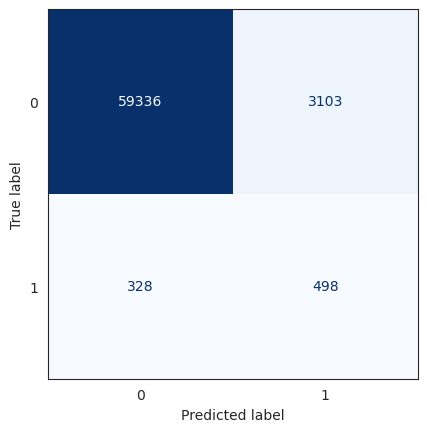

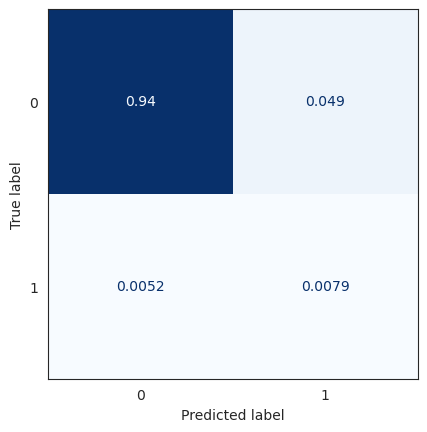

In [8]:
sns.set_style('white')
plotting.plot_confusion_matrix(y_true=val[LABEL_COL], y_pred=val[DECISION_COL], normalize=None)
plotting.plot_confusion_matrix(y_true=val[LABEL_COL], y_pred=val[DECISION_COL], normalize='all')
sns.set_style('whitegrid')

# 1. Random Search

## 1.1 '-log_loss' vs. 'roc_auc'

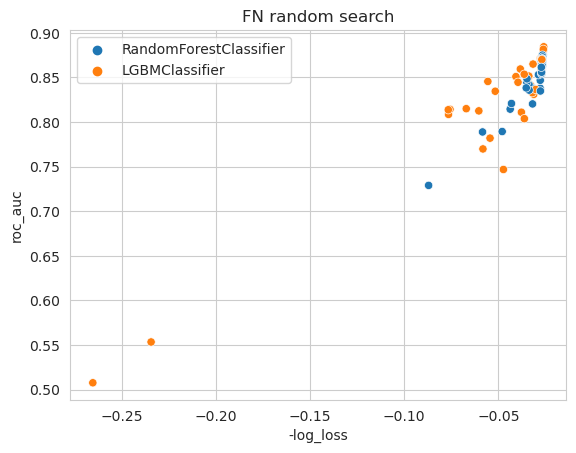

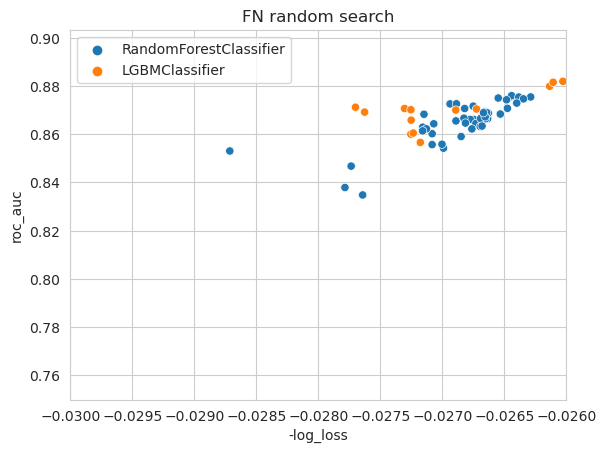

In [9]:
fn_model_tuner.plot_search(x='-log_loss', y='roc_auc', hue='algorithm', title='FN random search')
# zoom in
fn_model_tuner.plot_search(x='-log_loss', y='roc_auc', hue='algorithm', title='FN random search', show=False)
plt.xlim(-0.030, -0.026)
plt.ylim(bottom=0.75)
plt.show()

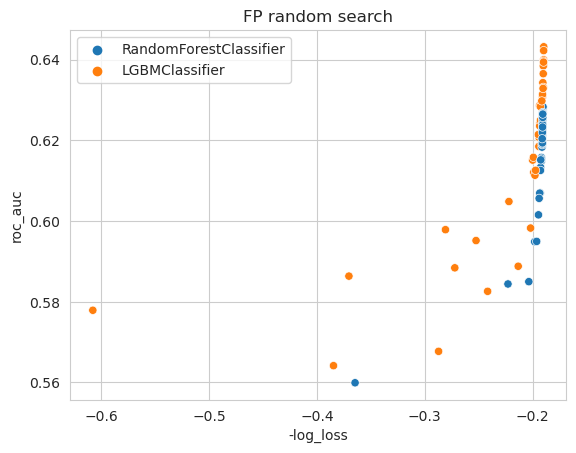

In [10]:
fp_model_tuner.plot_search(x='-log_loss', y='roc_auc', hue='algorithm', title='FP random search')

## 1.2 'trial' vs. '-log_loss'

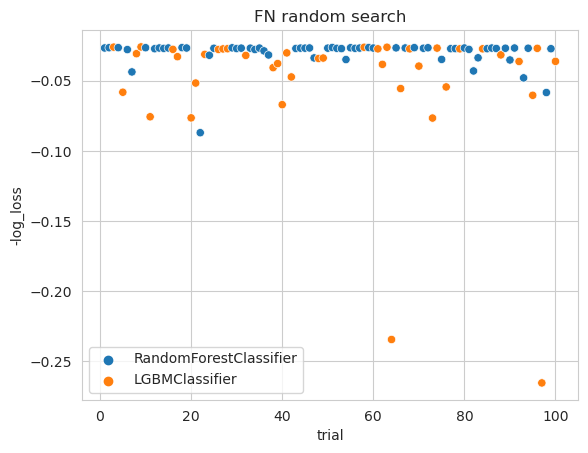

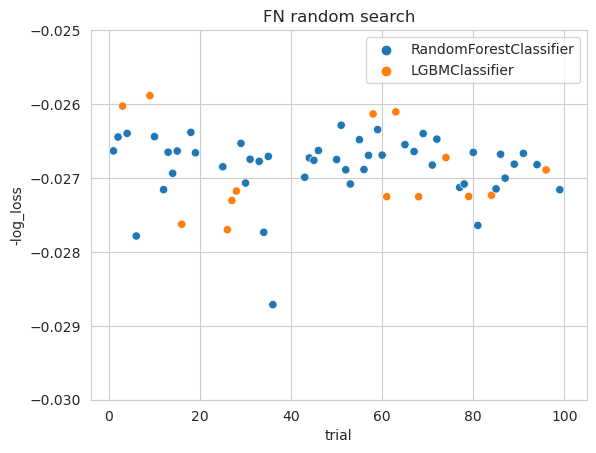

In [11]:
fn_model_tuner.plot_search(x='trial', y='-log_loss', hue='algorithm', title='FN random search')
# zoom in
fn_model_tuner.plot_search(x='trial', y='-log_loss', hue='algorithm', title='FN random search', show=False)
plt.ylim(-0.030, -0.025)
plt.show()

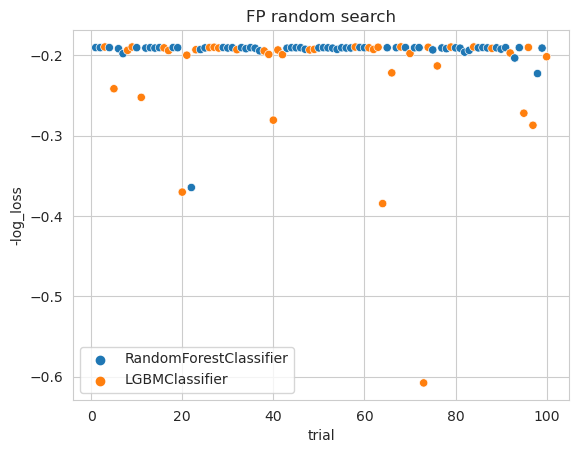

In [12]:
fp_model_tuner.plot_search(x='trial', y='-log_loss', hue='algorithm', title='FP random search')

## 1.3 'trial' vs. 'roc_auc'

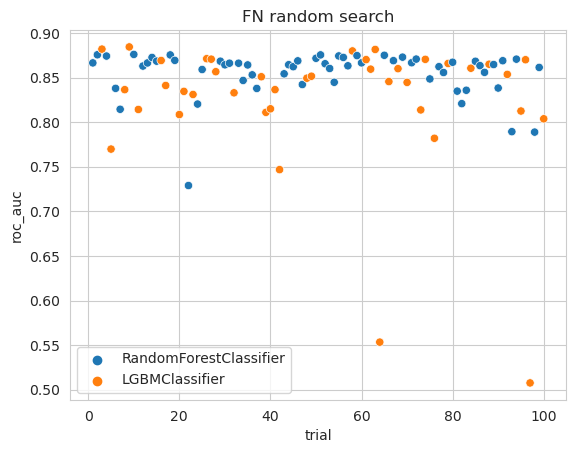

In [13]:
fn_model_tuner.plot_search(x='trial', y='roc_auc', hue='algorithm', title='FN random search')

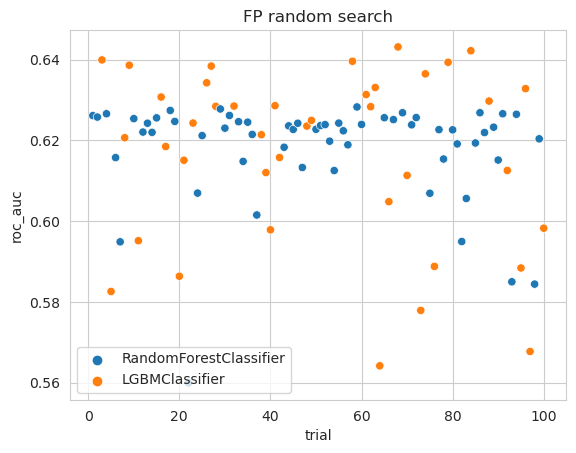

In [14]:
fp_model_tuner.plot_search(x='trial', y='roc_auc', hue='algorithm', title='FP random search')

# 2. TPE
Hyperoptimizing '-log_loss'

In [15]:
print('Hyperparameter tuning results')
print('')
print('FN')
print(f'RS(-log_loss) = {max(fn_model_tuner.values_hist):.6f}')
print(f'TPE(-log_loss) = {max(fn_model_tuner.values_hist):.6f}')
print('')
print('FP')
print(f'RS(-log_loss) = {max(fp_model_tuner.values_hist):.6f}')
print(f'TPE(-log_loss) = {max(fp_model_tuner.values_hist):.6f}')

Hyperparameter tuning results

FN
RS(-log_loss) = -0.025887
TPE(-log_loss) = -0.025887

FP
RS(-log_loss) = -0.189704
TPE(-log_loss) = -0.189704


## 2.1 'trial' vs. '-log_loss'

In [ ]:
fn_model_tuner.plot_search(x='trial', y='-log_loss', hue='algorithm', title='FN TPE search')
fn_model_tuner.plot_search(x='trial', y='-log_loss', hue='algorithm', title='FN TPE search', show=False)
plt.ylim(bottom=-0.030)
plt.show()

In [ ]:
fp_model_tuner.plot_search(x='trial', y='-log_loss', hue='algorithm', title='FP TPE search')

# 3. Analytics

In [ ]:
def plot_expert_roc_curves(
        y_true,
        y_score,
        assignments=val[ASSIGNMENT_COL],
        expert_ids=EXPERT_IDS_ENCODED,
        **kwargs
):
    plotting.plot_independent_roc_curves(
        labels_dict={
            expert_id: y_true[assignments == expert_id]
            for expert_id in expert_ids
        },
        scores_dict={
            expert_id: y_score[assignments == expert_id]
            for expert_id in expert_ids
        },
        alpha=0.5,
        ** kwargs
    )


def plot_roc_auc_by_expert(
        y_true,
        y_score,
        assignments=val[ASSIGNMENT_COL],
        expert_ids=EXPERT_IDS_ENCODED,
        title=None,
):
    roc_auc_by_expert_dict = {
        expert_id: metrics.roc_auc_score(
            y_true=y_true[assignments == expert_id],
            y_score=y_score[assignments == expert_id]
        )
        for expert_id in expert_ids
        if y_true[assignments == expert_id].size != 0
    }
    roc_auc_by_expert = pd.DataFrame(
        [roc_auc_by_expert_dict.keys(),
         roc_auc_by_expert_dict.values()]
    ).T
    roc_auc_by_expert.columns = ['expert', 'roc_auc']
    
    expert_encoding_mapping = dict(zip(
        range(len(oe.categories_[-1])),
        oe.categories_[-1]
    ))
    roc_auc_by_expert['expert'] = roc_auc_by_expert['expert'].map(expert_encoding_mapping)
    
    roc_auc_by_expert['type'] = roc_auc_by_expert['expert'].apply(lambda x: x.split('#')[0])

    all_data = roc_auc_by_expert.sort_values(by='roc_auc')
    palette = ['#000000', '#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7']
    types = list(roc_auc_by_expert['type'].unique())
    for t in types:
        plot_data = all_data[all_data['type'] == t]
        plt.bar(x=plot_data['expert'], height=plot_data['roc_auc'], color=palette[types.index(t)], label=t)
    plt.xlabel('experts')
    plt.ylabel('roc_auc')
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.xticks([])
    plt.title(title)
    plt.show()

## 3.1 FN model

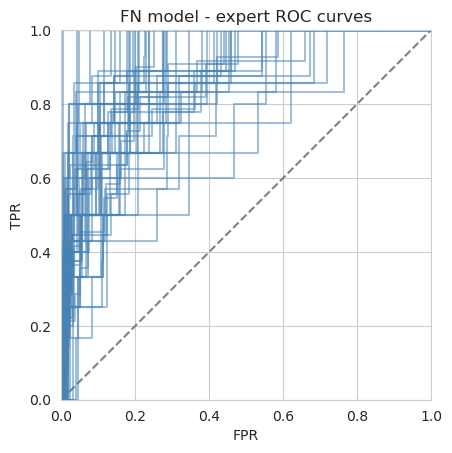

In [19]:
plot_expert_roc_curves(
    y_true=fn_model_tuner.y_val,
    y_score=fn_model_tuner.preds_hist[fn_model_tuner.best_model_ix],
    title='FN model - expert ROC curves',
)

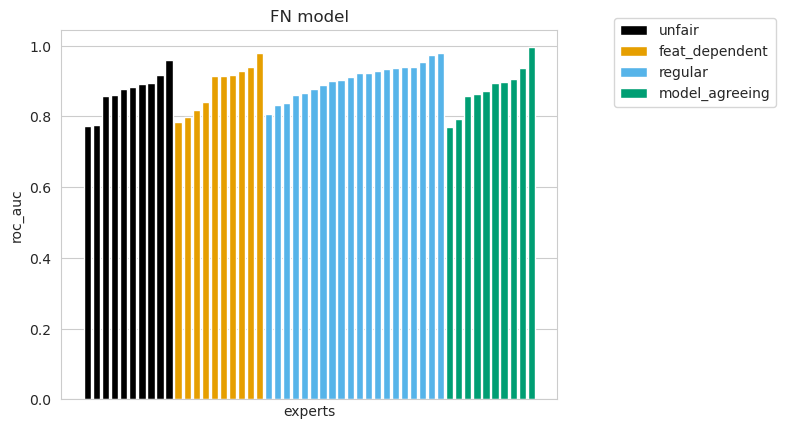

In [20]:
plot_roc_auc_by_expert(
    y_true=fn_model_tuner.y_val,
    y_score=fn_model_tuner.preds_hist[fn_model_tuner.best_model_ix],
    title='FN model',
)

## 3.2 FP model

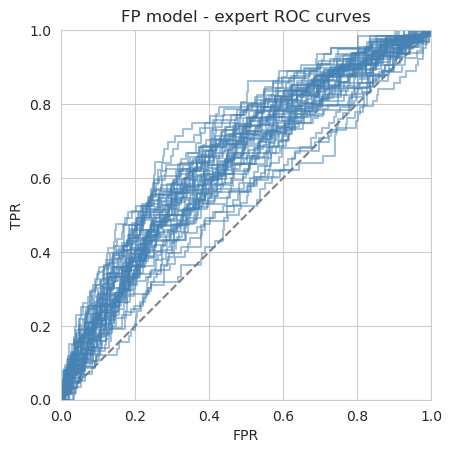

In [21]:
plot_expert_roc_curves(
    y_true=fp_model_tuner.y_val,
    y_score=fp_model_tuner.preds_hist[fp_model_tuner.best_model_ix],
    title='FP model - expert ROC curves',
)

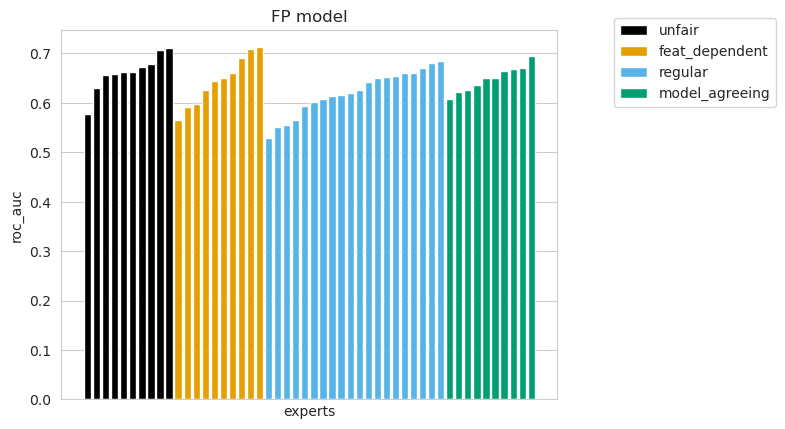

In [22]:
plot_roc_auc_by_expert(
    y_true=fp_model_tuner.y_val,
    y_score=fp_model_tuner.preds_hist[fp_model_tuner.best_model_ix],
    title='FP model',
)

## 3.3 PP model

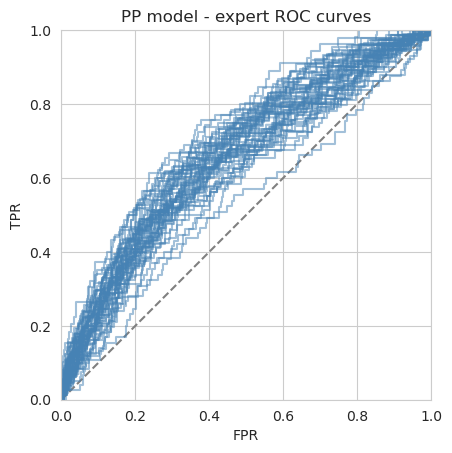

In [23]:
plot_expert_roc_curves(
    y_true=pp_model_tuner.y_val,
    y_score=pp_model_tuner.preds_hist[pp_model_tuner.best_model_ix],
    title='PP model - expert ROC curves',
)

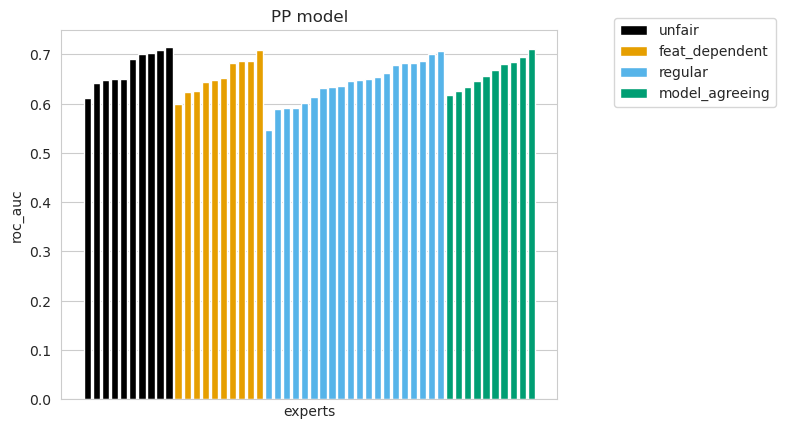

In [24]:
plot_roc_auc_by_expert(
    y_true=pp_model_tuner.y_val,
    y_score=pp_model_tuner.preds_hist[pp_model_tuner.best_model_ix],
    title='PP model',
)

## 3.4 Multiclass model

In [25]:
multiclass_model_pred = multiclass_model_tuner_tpe.preds_hist[multiclass_model_tuner_tpe.best_model_ix]

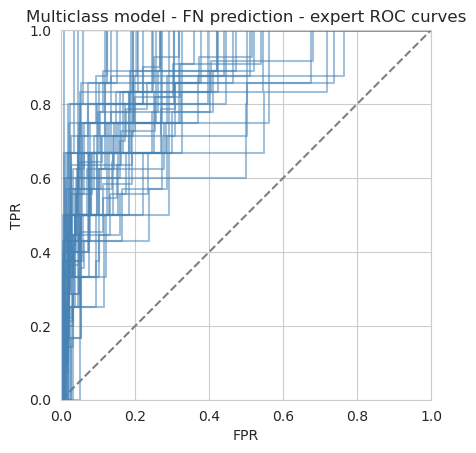

In [26]:
multiclass_model_pred_fn = multiclass_model_pred[:, multiclass_model_tuner_tpe.best_model.classes_ == 'fn']
plot_expert_roc_curves(
    y_true=fn_model_tuner_tpe.y_val,
    y_score=multiclass_model_pred_fn,
    title='Multiclass model - FN prediction - expert ROC curves',
)

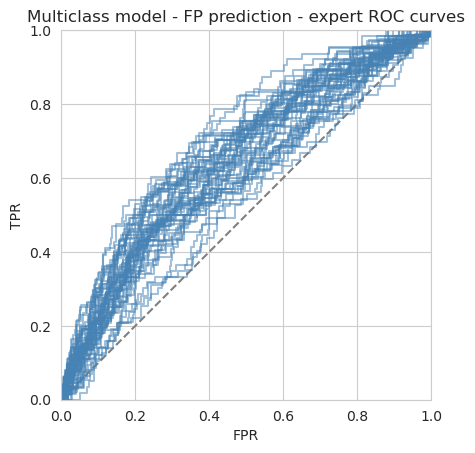

In [27]:
multiclass_model_pred_fp = multiclass_model_pred[:, multiclass_model_tuner_tpe.best_model.classes_ == 'fp']
plot_expert_roc_curves(
    y_true=fp_model_tuner_tpe.y_val,
    y_score=multiclass_model_pred_fp,
    title='Multiclass model - FP prediction - expert ROC curves',
)

In [28]:
print('FN prediction')
print(f'FN_model(-log_loss) = {max(fn_model_tuner.values_hist):.6f}')
print(f'Multiclass_model(-log_loss) = {-metrics.log_loss(y_true=fn_model_tuner.y_val, y_pred=multiclass_model_pred_fn):.6f}')
print('')
print('FP prediction')
print(f'FP_model(-log_loss) = {max(fp_model_tuner.values_hist):.6f}')
print(f'Multiclass_model(-log_loss) = {-metrics.log_loss(y_true=fp_model_tuner.y_val, y_pred=multiclass_model_pred_fp):.6f}')

FN prediction
FN_model(-log_loss) = -0.025887
Multiclass_model(-log_loss) = -0.025908

FP prediction
FP_model(-log_loss) = -0.189704
Multiclass_model(-log_loss) = -0.189650


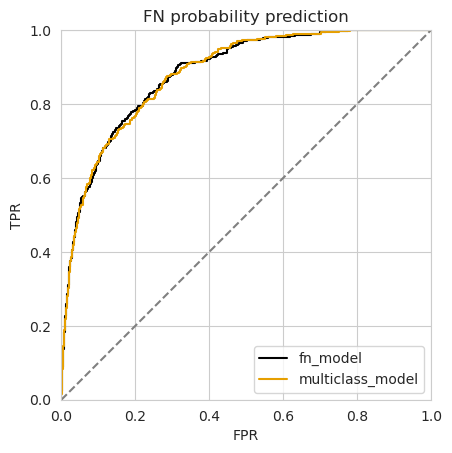

In [29]:
plotting.plot_roc_curves(
    y_true=fn_model_tuner_tpe.y_val,
    scores_dict={
        'fn_model': fn_model_tuner_tpe.preds_hist[fn_model_tuner_tpe.best_model_ix],
        'multiclass_model': multiclass_model_pred_fn,
    },
    title='FN probability prediction'
)

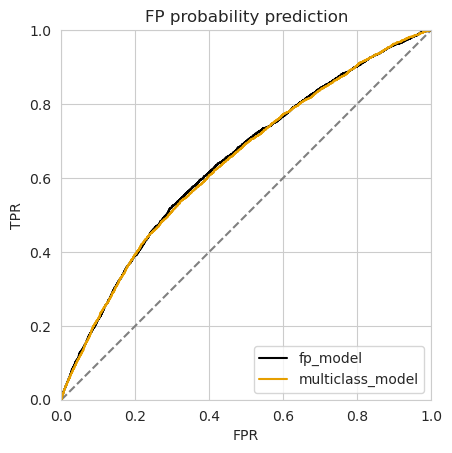

In [30]:
plotting.plot_roc_curves(
    y_true=fp_model_tuner_tpe.y_val,
    scores_dict={
        'fp_model': fp_model_tuner_tpe.preds_hist[fp_model_tuner_tpe.best_model_ix],
        'multiclass_model': multiclass_model_pred_fp,
    },
    title='FP probability prediction'
)